In [40]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
connect('mongoengine_documents')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from monary import Monary
mon = Monary()

from scoping.models import *

from mongo_classes import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

In [17]:
corpus_1990 = list(scopus_doc.objects.filter(PY=1990).values_list('TI'))
len(corpus_1990)

1658

In [11]:
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus_1990)

In [12]:
X.get_feature_names() 

AttributeError: get_feature_names not found

In [37]:
corpus_1995 = list(scopus_doc.objects.filter(PY=1995).values_list('TI'))
X_1995 = vectorizer.fit_transform(corpus_1995)

X = []
for y in [1990,1995,2000,2005,2010,2015]:
    corpus = list(scopus_doc.objects.filter(PY=y,TI__exists=True).values_list('TI'))
    X_y = vectorizer.fit_transform(corpus)
    X.append(X_y)


In [77]:
import nltk
from nltk.stem import SnowballStemmer
import string

stoplist = set(nltk.corpus.stopwords.words("english"))
stoplist.add('elsevier')
stoplist.add('rights')
stoplist.add('reserved')
stoplist.add('john')
stoplist.add('wiley')
stoplist.add('sons')
stoplist.add('copyright')

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    return tokens

class snowball_stemmer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in tokenize(doc)]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   tokenizer=snowball_stemmer(),
                                   stop_words=stoplist)

c_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                   tokenizer=snowball_stemmer(),
                                   stop_words=stoplist)

tfidf = tfidf_vectorizer.fit_transform(corpus_1995)

In [51]:
dir(tfidf)
tfidf.shape
print(len(corpus_1995))
print(tfidf.shape)

2877
(2877, 1997)


In [60]:
X = []
for y in [1990,1995,2000,2005,2010,2015]:
    print(y)
    corpus = list(scopus_doc.objects.filter(PY=y,AB__exists=True).values_list('AB'))
    X_y = tfidf_vectorizer.fit_transform(corpus)
    X.append(X_y)

1990
1995
2000
2005
2010
2015


In [78]:
X_count = []
for y in [1990,1995,2000,2005,2010,2015]:
    print(y)
    corpus = list(scopus_doc.objects.filter(PY=y,AB__exists=True).values_list('AB'))
    X_y = c_vectorizer.fit_transform(corpus)
    X_count.append(X_y)

1990
1995
2000
2005
2010
2015


In [82]:
print(X_count[0].sum())
for x in X_count:
    print(x.mean()/x.sum())

133477
1.28137708057e-07
4.89973380726e-08
1.47520445375e-08
4.27161621914e-09
1.30881214962e-09
6.05723515418e-10


#D53E4F
0.0948979026053
#FC8D59
0.0995278832749
#FEE08B
0.119038546515
#E6F598
0.188054283882
#99D594
0.413566458852
#3288BD
0.93472178038


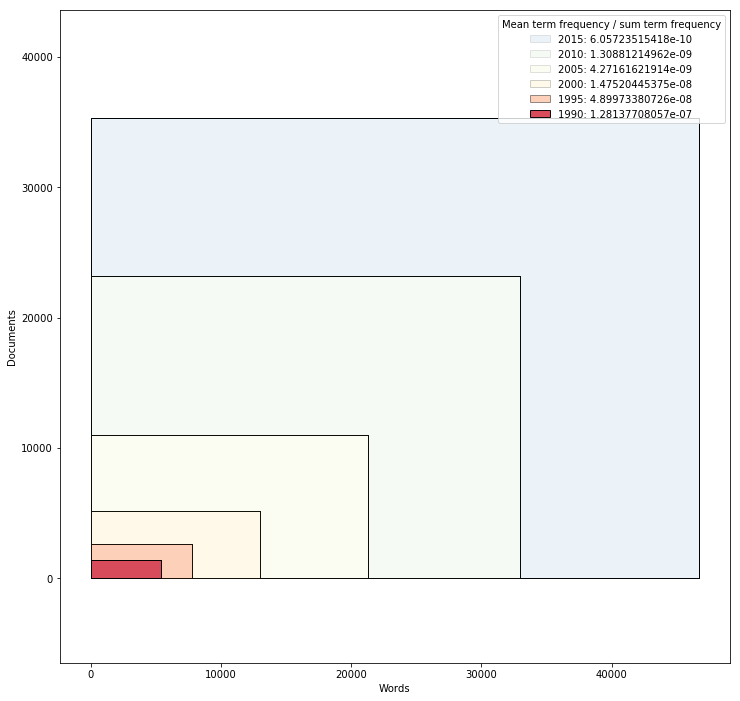

In [178]:
ind = np.arange(1)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def vvrect(X,col_x,m):
    return plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],facecolor=col_x,edgecolor='black',alpha=m)

nmeans = normalize([[x.mean()/x.sum() for x in X_count]])[0]

crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD"]
years = [1990,1995,2000,2005,2010,2015]



plots = []
lvalues = []
for x in [5,4,3,2,1,0]:
    a = (nmeans[x]+0.1)/1.1
    #a = nmeans[x]
    vvrect(X_count[x], "None",1)
    vvrect(X_count[x], "white",1)
    p = vvrect(X_count[x], crange[x] ,a)
    plots.append(p[0])
    lvalues.append(str(years[x]) + ": " + str(X_count[x].mean()/X_count[x].sum()))
    print(crange[5-x])
    print(a)
    
plt.legend(plots,lvalues,title='Mean term frequency / sum term frequency')
    
plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety.png',bbox_inches='tight')

plt.show()

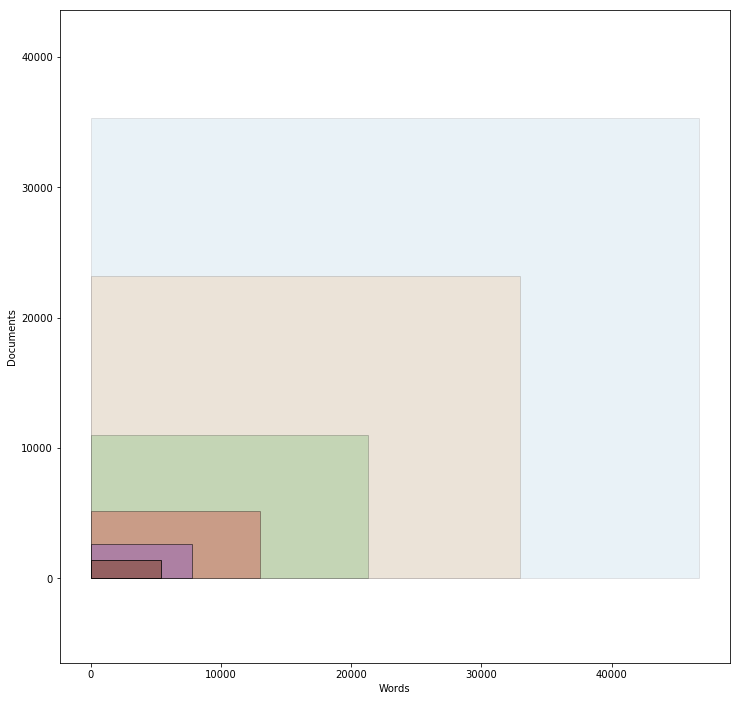

In [108]:
ind = np.arange(1)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def vvrect(X,colour,m):
    plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],fill=colour,edgecolor='black',alpha=m)
    
nmeans = normalize([[x.mean() for x in X]])[0]



   

vvrect(X[5], '#fbb4ae',nmeans[5])
vvrect(X[4], '#b3cde3',nmeans[4])
vvrect(X[3], '#ccebc5',nmeans[3])
vvrect(X[2], '#decbe4',nmeans[2])
vvrect(X[1], '#fed9a6',nmeans[1])
vvrect(X[0], '#ffffcc',nmeans[0])

plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety.png',bbox_inches='tight')

plt.show()

In [56]:
print(X[1].shape)

(2877, 1997)


In [66]:
x = X[1]

In [67]:
dir(x)

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__numpy_ufunc__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_binopt',
 '_boolean_index_to_array',
 '_check_boolean',
 '_check_ellipsis',
 '_cs_matrix__get_has_canonical_format',
 '_cs_matrix__get_sorted',
 '_cs_matrix__set_has_canonical_format',
 '_cs_matrix__set_sorted',
 '_deduped_data',
 '_di

In [68]:
for x in X:
    print(x.mean())

0.00125491114092
0.000879825371994
0.000547628018673
0.00033694434578
0.000219688444785
0.00015556117685


In [69]:
means = [x.mean() for x in X]

In [72]:
from sklearn.preprocessing import normalize

normalize([means])

array([[ 0.74533741,  0.52256032,  0.32525622,  0.20012351,  0.13048096,
         0.09239345]])

In [175]:
import codecs
import re
bible = []
i=0
clines=""
corpus = []
lchapter="none"
with codecs.open('Martin_Luther_Uebersetzung_1912.txt',encoding = "ISO-8859-1") as ml:
    for line in ml:
        chapter = line.split(':')[0]
        try:
            verse = re.search(".*([0-9]+\:[0-9]*)(.*)",line).group(2).strip()
        except:
            corpus.append(str(clines))
            break
        if lchapter!=chapter and i > 0:
            corpus.append(str(clines))
            clines=verse            
        else:
            clines+=" "+verse
            #print('\n')
        lchapter = chapter
        i+=1



In [176]:
len(corpus)

1189

In [179]:
X_y = c_vectorizer.fit_transform(corpus)

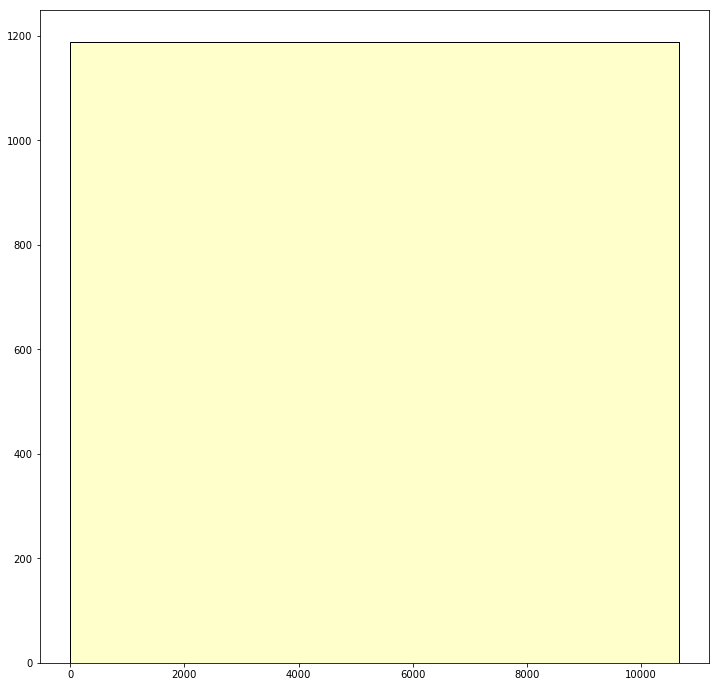

In [181]:
vvrect(X_y, '#ffffcc',1)
plt.show()

#D53E4F
0.0940115584193
#FC8D59
0.0976127222983
#FEE08B
0.112787968315
#E6F598
0.16646788584
#99D594
0.341869546607
#3288BD
0.747220206393
grey
0.494937845835


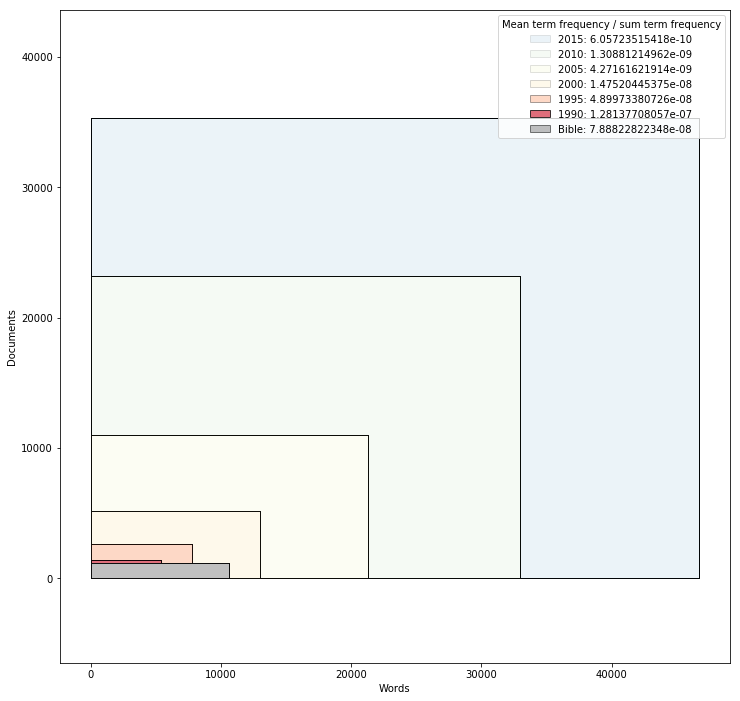

In [187]:
ind = np.arange(1)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def vvrect(X,col_x,m):
    return plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],facecolor=col_x,edgecolor='black',alpha=m)

#X_count.append(X_y)

nmeans = normalize([[x.mean()/x.sum() for x in X_count]])[0]

crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD","grey"]
years = [1990,1995,2000,2005,2010,2015,'Bible']



plots = []
lvalues = []
for x in [5,4,3,2,1,0,6]:
    a = (nmeans[x]+0.1)/1.1
    #a = nmeans[x]
    vvrect(X_count[x], "None",1)
    vvrect(X_count[x], "white",1)
    p = vvrect(X_count[x], crange[x] ,a)
    plots.append(p[0])
    lvalues.append(str(years[x]) + ": " + str(X_count[x].mean()/X_count[x].sum()))
    print(crange[5-x])
    print(a)
    
plt.legend(plots,lvalues,title='Mean term frequency / sum term frequency')
    
plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety_bible.png',bbox_inches='tight')

plt.show()